In [1]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.3 MB/s eta 0:00:0000:0100:01


In [2]:
import warnings
warnings.filterwarnings('ignore')

Using device: cpu
Dataset Type         |  Samples |   Percentage
---------------------------------------------
Full dataset         |   100000 |         100%
Subset (10%)         |    10000 |          10%
Training set         |     8000 | 80% of subset
Test set             |     2000 | 20% of subset
---------------------------------------------
Train batches        |       32 | (batch size: 16
Test batches         |        8 | (batch size: 16)
Starting training...



Epoch 1/10:
Train Loss: 0.6383 | Train Acc: 63.71%
Test Loss: 0.6099 | Test Acc: 65.30%


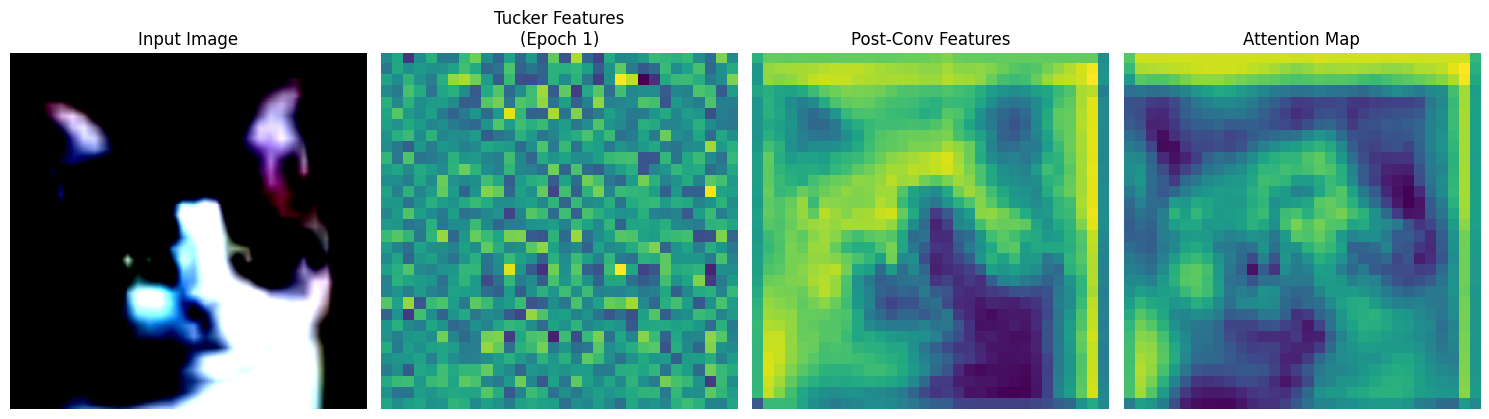


Epoch 2/10:
Train Loss: 0.5031 | Train Acc: 75.74%
Test Loss: 0.4603 | Test Acc: 78.30%


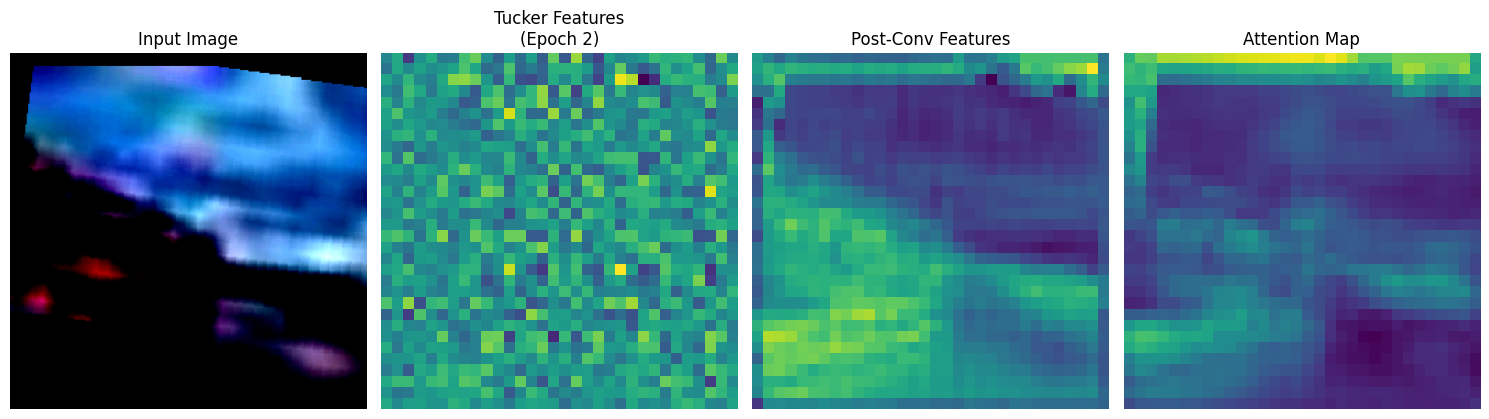


Epoch 3/10:
Train Loss: 0.4583 | Train Acc: 78.97%
Test Loss: 0.4430 | Test Acc: 80.60%


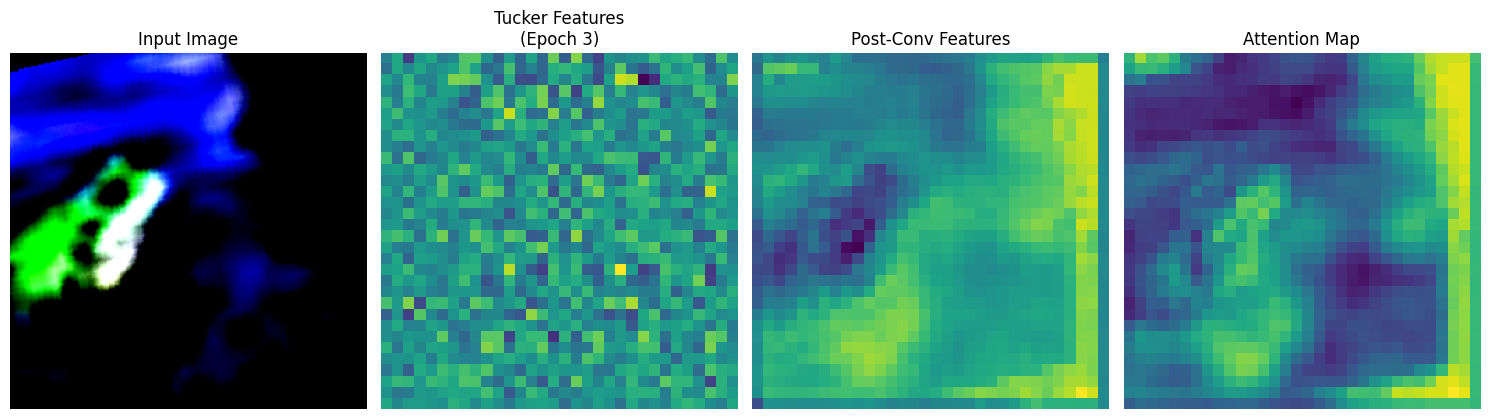


Epoch 4/10:
Train Loss: 0.4225 | Train Acc: 80.96%
Test Loss: 0.3882 | Test Acc: 82.30%


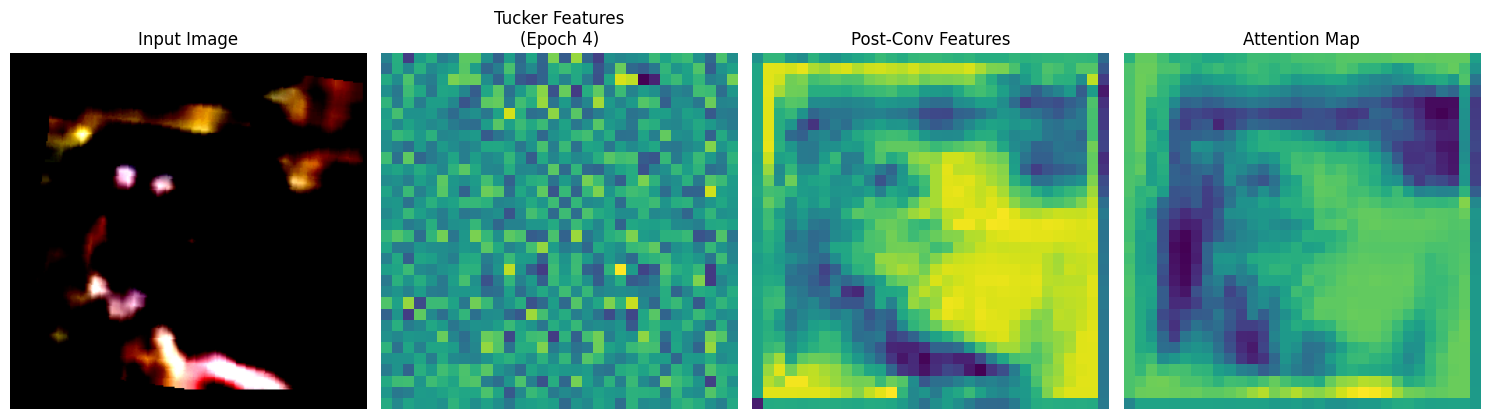


Epoch 5/10:
Train Loss: 0.4068 | Train Acc: 81.86%
Test Loss: 0.4812 | Test Acc: 77.75%


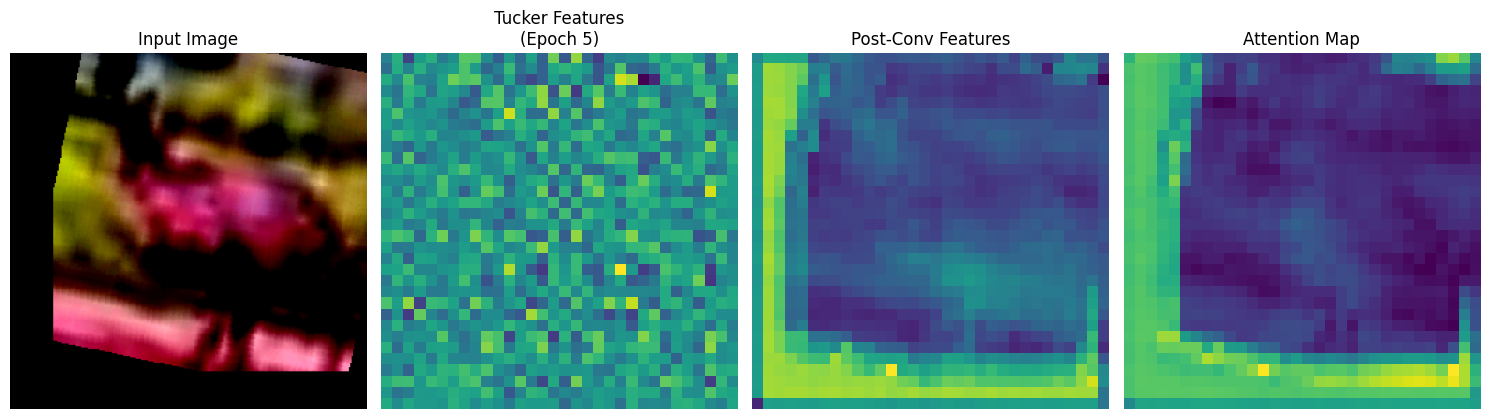


Epoch 6/10:
Train Loss: 0.3909 | Train Acc: 82.84%
Test Loss: 0.3830 | Test Acc: 83.65%


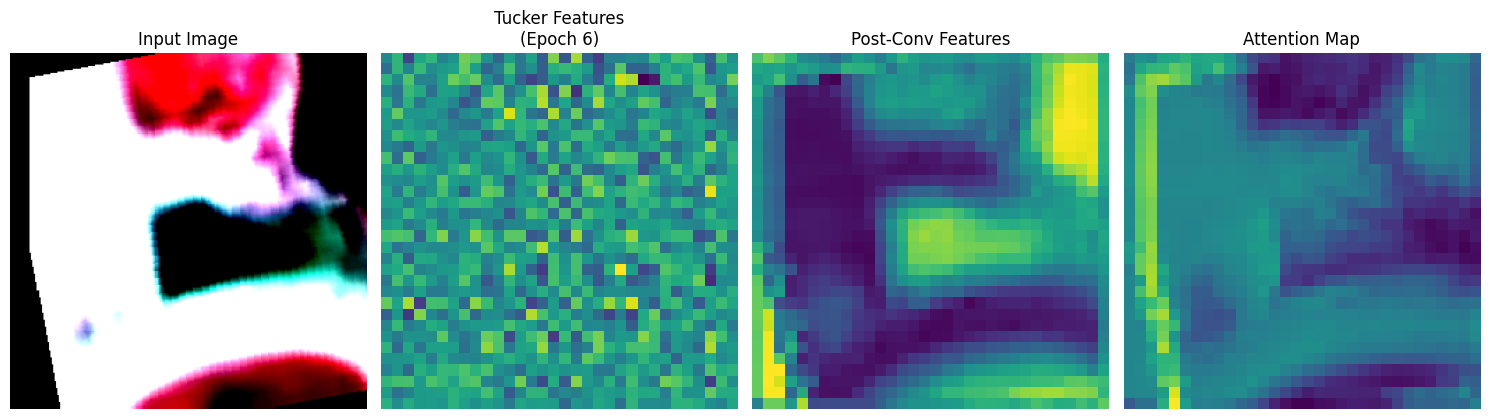


Epoch 7/10:
Train Loss: 0.3642 | Train Acc: 84.36%
Test Loss: 0.4174 | Test Acc: 81.80%


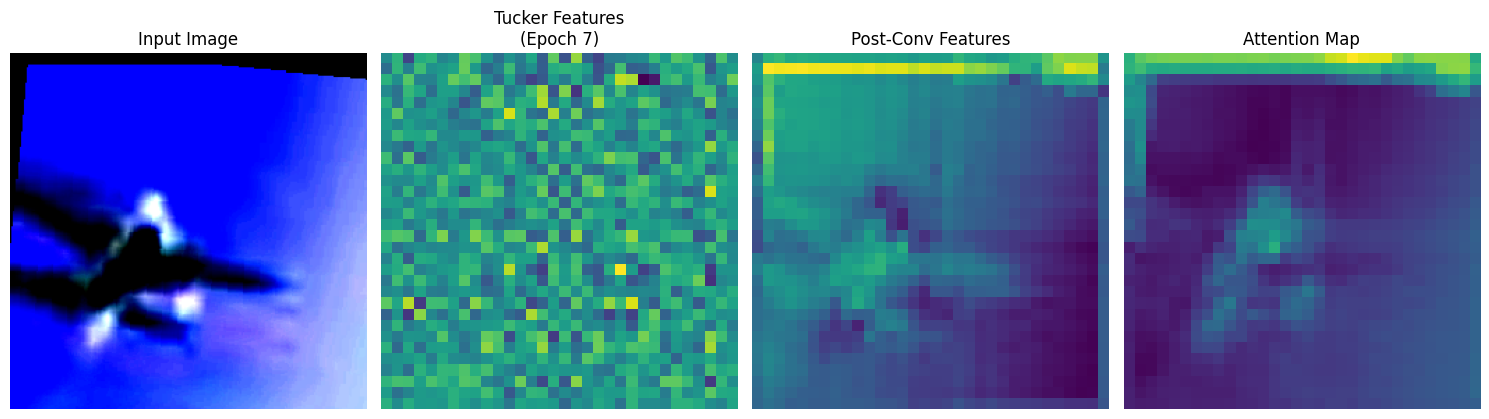


Epoch 8/10:
Train Loss: 0.3616 | Train Acc: 84.08%
Test Loss: 0.3823 | Test Acc: 82.60%


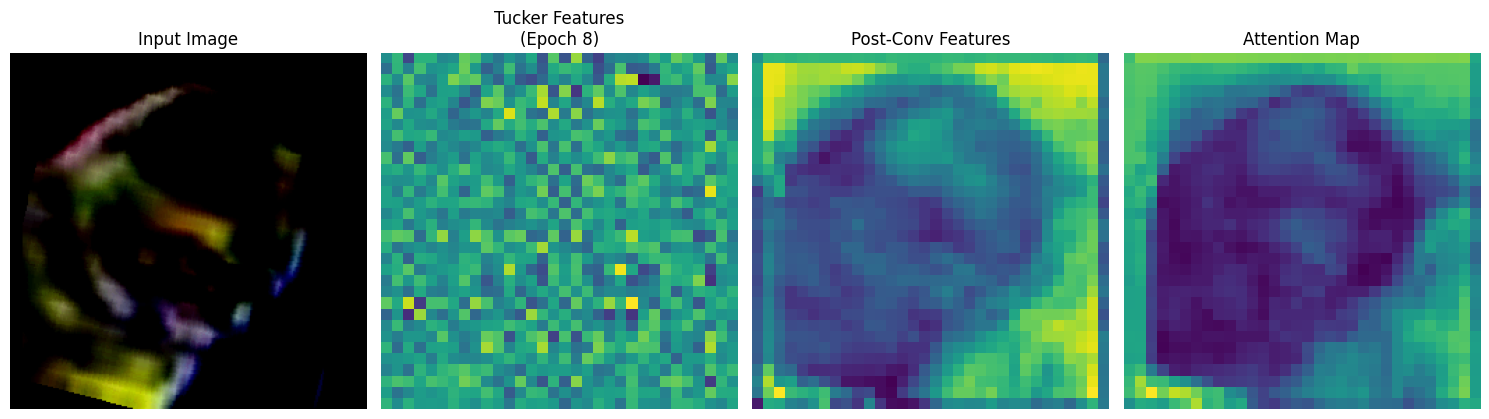


Epoch 9/10:
Train Loss: 0.3402 | Train Acc: 85.56%
Test Loss: 0.3658 | Test Acc: 84.50%


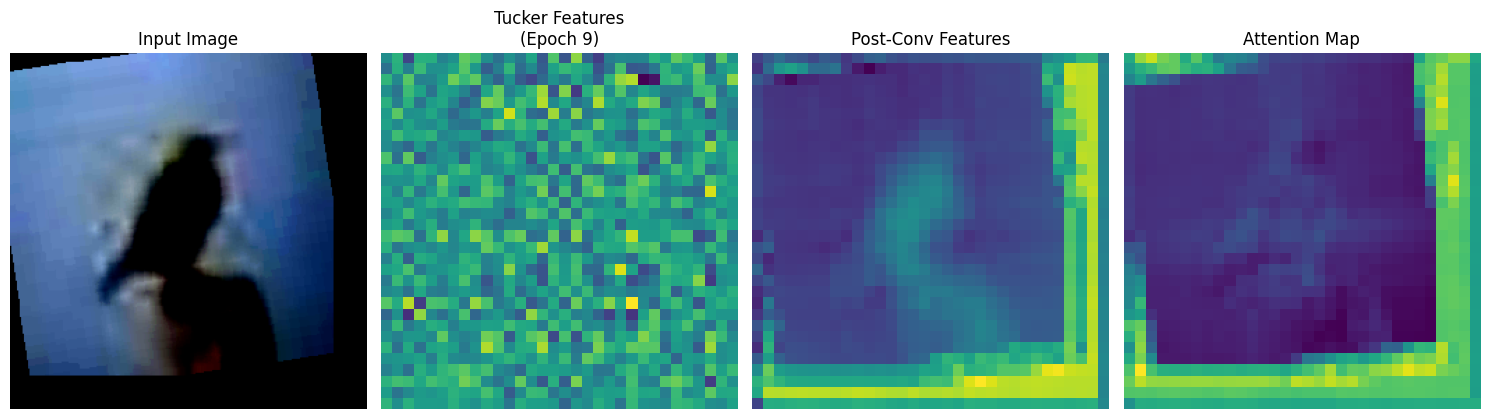


Epoch 10/10:
Train Loss: 0.3188 | Train Acc: 86.59%
Test Loss: 0.3159 | Test Acc: 87.25%


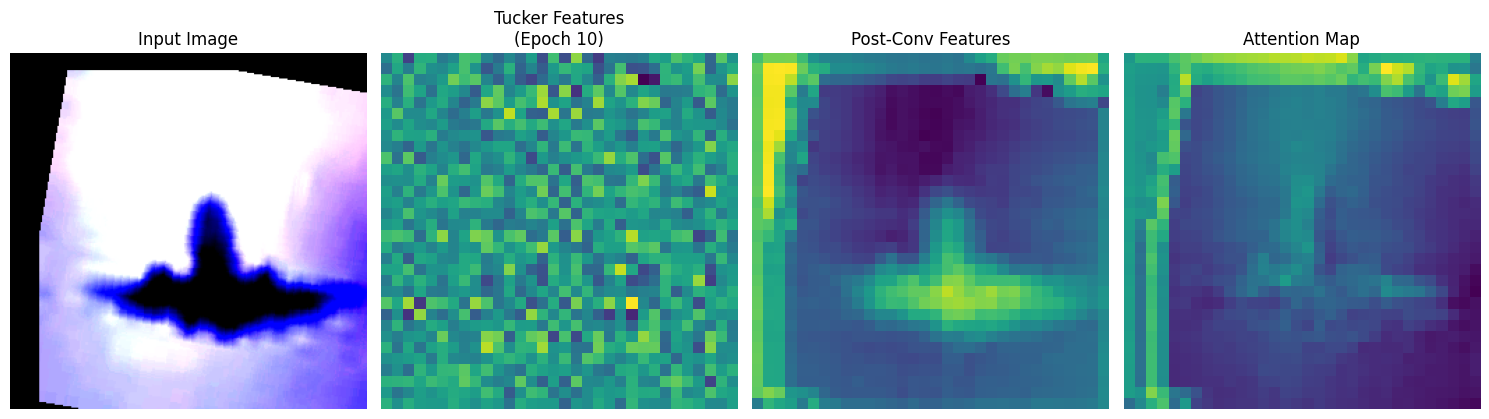

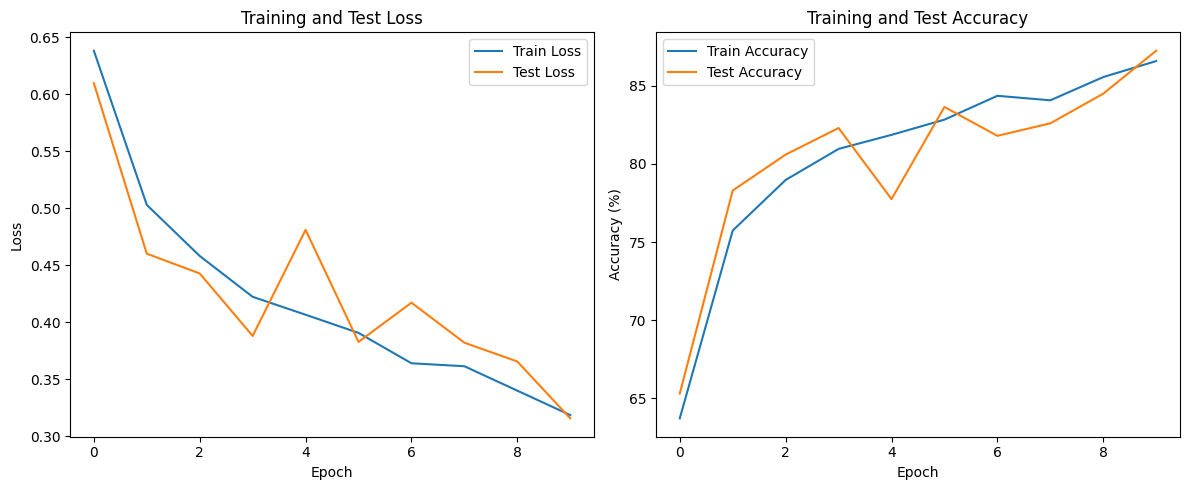

Model saved to real_fake_fusion_model.pth


In [4]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from scipy.fftpack import dct
from tensorly.decomposition import tucker
import tensorly as tl
from torch.utils.data import Subset
tl.set_backend('pytorch')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class RealFakeDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.jpg')]
        self.fake_paths = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.jpg')]
        self.data = [(path, 0) for path in self.real_paths] + [(path, 1) for path in self.fake_paths]
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# Feature Extraction Functions remain the same
def extract_dct_features(image_tensor, block_size=8):
    # Ensure we have a single image (C,H,W)
    if len(image_tensor.shape) == 4:  # If batched, take first image
        image_tensor = image_tensor[0]  # Now shape is [C,H,W]
    
    # Convert to numpy array in HWC format
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Convert to grayscale
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    
    h, w = image_gray.shape
    dct_features = np.zeros((h//block_size, w//block_size, block_size*block_size))
    
    for i in range(0, h, block_size):
        if i + block_size > h:
            continue
        for j in range(0, w, block_size):
            if j + block_size > w:
                continue
            block = image_gray[i:i+block_size, j:j+block_size]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            dct_features[i//block_size, j//block_size, :] = dct_block.flatten()
    
    # Return as tensor
    return torch.from_numpy(dct_features).float().to(device)

def extract_fft_features(image_tensor):
    # Ensure we have a single image (C,H,W)
    if len(image_tensor.shape) == 4:  # If batched, take first image
        image_tensor = image_tensor[0]  # Now shape is [C,H,W]
        
    # Apply FFT to each channel
    image_np = image_tensor.cpu().numpy()
    fft_features = np.zeros_like(image_np)
    
    for c in range(image_np.shape[0]):
        fft_result = np.fft.fft2(image_np[c])
        fft_shifted = np.fft.fftshift(fft_result)
        fft_magnitude = np.log(np.abs(fft_shifted) + 1)
        fft_features[c] = fft_magnitude
    
    # Downsample to match DCT feature dimensions
    h, w = fft_features.shape[1:]
    block_size = 8
    fft_features_downsampled = np.zeros((3, h//block_size, w//block_size))
    
    for c in range(3):
        for i in range(0, h, block_size):
            if i + block_size > h:
                continue
            for j in range(0, w, block_size):
                if j + block_size > w:
                    continue
                block = fft_features[c, i:i+block_size, j:j+block_size]
                fft_features_downsampled[c, i//block_size, j//block_size] = np.mean(block)
    
    return torch.from_numpy(fft_features_downsampled).float().to(device)

def extract_entropy_features(image_tensor, window_size=8):
    # Ensure we have a single image (C,H,W)
    if len(image_tensor.shape) == 4:  # If batched, take first image
        image_tensor = image_tensor[0]  # Now shape is [C,H,W]
    
    # Convert to numpy array in HWC format
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Convert to grayscale
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    
    h, w = image_gray.shape
    entropy_features = np.zeros((h//window_size, w//window_size))
    
    for i in range(0, h, window_size):
        if i + window_size > h:
            continue
        for j in range(0, w, window_size):
            if j + window_size > w:
                continue
            window = image_gray[i:i+window_size, j:j+window_size]
            
            # Calculate entropy
            hist = cv2.calcHist([window], [0], None, [256], [0, 256])
            hist = hist / (window_size * window_size)
            non_zero_hist = hist[hist > 0]
            entropy = -np.sum(non_zero_hist * np.log2(non_zero_hist)) if len(non_zero_hist) > 0 else 0
            
            entropy_features[i//window_size, j//window_size] = entropy
    
    # Return as tensor with channel dimension
    return torch.from_numpy(entropy_features).unsqueeze(0).float().to(device)

def visualize_features(model, sample, epoch):
    model.eval()
    
    # Ensure sample has batch dimension
    if len(sample.shape) == 3:  # [C,H,W]
        sample = sample.unsqueeze(0).to(device)  # Add batch dimension -> [1,C,H,W]
    else:
        # If it already has batch dimension, make sure it's on the right device
        sample = sample.to(device)
    
    # Hook to capture intermediate features
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks at key layers
    hooks = [
        model.tucker_layer.register_forward_hook(get_activation('tucker')),
        model.initial_conv.register_forward_hook(get_activation('initial_conv')),
        model.attention.register_forward_hook(get_activation('attention'))
    ]
    
    # Forward pass to capture features
    with torch.no_grad():
        _ = model(sample)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Visualize features
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 4, 1)
    plt.imshow(sample[0].cpu().permute(1, 2, 0))  # Use first image in batch
    plt.title('Input Image')
    plt.axis('off')
    
    # Tucker compressed features - handle batch dimension properly
    plt.subplot(1, 4, 2)
    tucker_feats = activations['tucker'][0].mean(dim=-1).cpu()  # Use first sample in batch
    plt.imshow(tucker_feats, cmap='viridis')
    plt.title(f'Tucker Features\n(Epoch {epoch+1})')
    plt.axis('off')
    
    # After first convolution - handle batch dimension properly
    plt.subplot(1, 4, 3)
    conv_feats = activations['initial_conv'][0].mean(dim=0).cpu()  # Use first sample in batch
    plt.imshow(conv_feats, cmap='viridis')
    plt.title('Post-Conv Features')
    plt.axis('off')
    
    # Attention map - handle batch dimension properly
    plt.subplot(1, 4, 4)
    attn_feats = activations['attention'][0].mean(dim=0).cpu()  # Use first sample in batch
    plt.imshow(attn_feats, cmap='viridis')
    plt.title('Attention Map')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Improved TuckerDecompositionLayer with better initialization
class TuckerDecompositionLayer(nn.Module):
    def __init__(self, input_dims, rank):
        super(TuckerDecompositionLayer, self).__init__()
        self.rank = rank
        self.input_dims = input_dims
        
        # Initialize factor matrices with Kaiming initialization
        self.U1 = nn.Parameter(torch.empty(input_dims[0], rank[0]))
        self.U2 = nn.Parameter(torch.empty(input_dims[1], rank[1]))
        self.U3 = nn.Parameter(torch.empty(input_dims[2], rank[2]))
        nn.init.kaiming_uniform_(self.U1, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.U2, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.U3, a=math.sqrt(5))
        
        # Initialize core tensor with smaller values to avoid exploding gradients
        self.core_tensor = nn.Parameter(torch.randn(rank) * 0.01)
        
    def forward(self, tensor):
        batch_size = tensor.shape[0]
        results = []
        
        # Apply tucker decomposition for each sample in batch
        for i in range(batch_size):
            # Mode-1 product
            tmp = torch.tensordot(self.core_tensor, self.U1, dims=([0], [1]))
            # Mode-2 product
            tmp = torch.tensordot(tmp, self.U2, dims=([0], [1]))
            # Mode-3 product
            tmp = torch.tensordot(tmp, self.U3, dims=([0], [1]))
            
            results.append(tmp)
        
        return torch.stack(results)


# ResNet-style basic block for our model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# Improved Attention Mechanism with Channel and Spatial Attention
class DualAttentionGating(nn.Module):
    def __init__(self, feature_dim):
        super(DualAttentionGating, self).__init__()
        
        # Spatial attention
        self.query_conv = nn.Conv2d(feature_dim, feature_dim // 4, kernel_size=1)
        self.key_conv = nn.Conv2d(feature_dim, feature_dim // 4, kernel_size=1)
        self.value_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)
        self.gamma_spatial = nn.Parameter(torch.zeros(1))
        
        # Channel attention
        self.mlp_channel = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 8),
            nn.ReLU(),
            nn.Linear(feature_dim // 8, feature_dim)
        )
        self.gamma_channel = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        # Spatial attention
        query = self.query_conv(x).view(batch_size, -1, H * W).permute(0, 2, 1)  # B x (H*W) x C'
        key = self.key_conv(x).view(batch_size, -1, H * W)  # B x C' x (H*W)
        value = self.value_conv(x).view(batch_size, -1, H * W)  # B x C x (H*W)
        
        # Compute spatial attention scores
        attention = F.softmax(torch.bmm(query, key), dim=2)  # B x (H*W) x (H*W)
        
        # Apply spatial attention to values
        spatial_out = torch.bmm(value, attention.permute(0, 2, 1))
        spatial_out = spatial_out.view(batch_size, C, H, W)
        
        # Channel attention
        avg_pool = F.adaptive_avg_pool2d(x, (1, 1)).view(batch_size, C)
        max_pool = F.adaptive_max_pool2d(x, (1, 1)).view(batch_size, C)
        
        avg_attention = self.mlp_channel(avg_pool).unsqueeze(-1).unsqueeze(-1)
        max_attention = self.mlp_channel(max_pool).unsqueeze(-1).unsqueeze(-1)
        
        channel_attention = torch.sigmoid(avg_attention + max_attention)
        channel_out = x * channel_attention
        
        # Combine both attention mechanisms
        out = x + self.gamma_spatial * spatial_out + self.gamma_channel * channel_out
        
        return out


# Import missing math module
import math

# Improved MultiDomainFeatureFusionModel with ResNet Architecture
class MultiDomainFeatureFusionModel(nn.Module):
    def __init__(self):
        super(MultiDomainFeatureFusionModel, self).__init__()
        
        # Define dimensions for feature tensor - for 256x256 input
        self.spatial_dim = 32  # 256/8 = 32
        self.feature_channels = 66  # 64 (DCT) + 1 (entropy) + 1 (FFT mean)
        
        # Tucker decomposition layer with improved dimensions
        self.tucker_rank = (16, 16, 33)  # Reduced rank for each dimension
        self.tucker_layer = TuckerDecompositionLayer(
            input_dims=(self.spatial_dim, self.spatial_dim, self.feature_channels),
            rank=self.tucker_rank
        )
        
        # Initial convolution layers
        self.initial_conv = nn.Conv2d(self.feature_channels, 64, kernel_size=3, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        
        # ResNet-style blocks
        self.res_block1 = ResidualBlock(64, 64)
        self.res_block2 = ResidualBlock(64, 128, stride=2)
        self.res_block3 = ResidualBlock(128, 256, stride=2)
        self.res_block4 = ResidualBlock(256, 512, stride=2)
        
        # Improved attention mechanism
        self.attention = DualAttentionGating(64)
        
        # Multi-scale feature aggregation with residual connections
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.local_pool = nn.AdaptiveAvgPool2d(4)
        self.local_conv = nn.Conv2d(512, 128, kernel_size=1)
        self.local_bn = nn.BatchNorm2d(128)
        
        # Feature transformation blocks with normalization
        self.fc_global = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU()
        )
        
        self.fc_local = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.LayerNorm(256),
            nn.ReLU()
        )
        
        # Final classification with dropout
        self.dropout = nn.Dropout(0.5)
        self.fc_final = nn.Linear(512, 2)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Extract features for each image in the batch
        all_features = []
        for i in range(batch_size):
            img = x[i]
            
            # Extract multi-domain features
            dct_features = extract_dct_features(img)
            fft_features = extract_fft_features(img)
            entropy_features = extract_entropy_features(img)
            
            # Prepare feature dimensions
            h, w = dct_features.shape[0], dct_features.shape[1]
            dct_reshape = dct_features.view(h, w, -1)
            
            # Average FFT features over channels
            fft_mean = torch.mean(fft_features, dim=0).unsqueeze(-1)
            
            # Reshape entropy features
            entropy_reshape = entropy_features.squeeze(0).unsqueeze(-1)
            
            # Concatenate all features for tensorization
            stacked_features = torch.cat([dct_reshape, entropy_reshape, fft_mean], dim=-1)
            all_features.append(stacked_features)
        
        # Stack batch
        feature_tensor = torch.stack(all_features).to(device)
        
        # Apply Tucker decomposition with learned parameters
        compressed_tensor = self.tucker_layer(feature_tensor)
        
        # Adaptive feature fusion with residual connection
        fused_features = feature_tensor + compressed_tensor * feature_tensor
        
        # Reshape for convolution (B, H, W, C) -> (B, C, H, W)
        fused_features = fused_features.permute(0, 3, 1, 2)
        
        # Initial feature transformation
        x = F.relu(self.bn0(self.initial_conv(fused_features)))
        
        # Apply dual attention gating
        x = self.attention(x)
        
        # ResNet feature extraction pathway
        x = self.res_block1(x)
        res2 = self.res_block2(x)
        res3 = self.res_block3(res2)
        res4 = self.res_block4(res3)
        
        # Enhanced multi-scale feature aggregation
        global_features = self.global_pool(res4).view(batch_size, -1)
        local_features = self.local_pool(res4)
        local_features = F.relu(self.local_bn(self.local_conv(local_features)))
        local_features = local_features.contiguous().reshape(batch_size, -1)
        
        # Final feature transformation
        global_feats = self.fc_global(global_features)
        local_feats = self.fc_local(local_features)
        
        # Combine features with regularization
        combined_features = torch.cat([global_feats, local_feats], dim=1)
        combined_features = self.dropout(combined_features)
        
        # Final classification
        logits = self.fc_final(combined_features)
        
        return logits

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Update dataset creation
full_dataset = RealFakeDataset(
    r"/kaggle/input/deepfake/REAL/REAL",
    r"/kaggle/input/deepfake/FAKE/FAKE",
    transform=transform_train  # Apply training augmentations
)

x = 0.1 
subset_size = int(x * len(full_dataset))
indices = torch.randperm(len(full_dataset))[:subset_size]
subset = Subset(full_dataset, indices)
# Now split this subset into train/test
train_size = int(0.8 * len(subset))
test_size = len(subset) - train_size
train_dataset, test_dataset = random_split(subset, [train_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

# Print dataset sizes
print(f"{'Dataset Type':<20} | {'Samples':>8} | {'Percentage':>12}")
print("-" * 45)
print(f"{'Full dataset':<20} | {len(full_dataset):>8} | {'100%':>12}")
print(f"{'Subset (10%)':<20} | {len(subset):>8} | {f'{x*100:.0f}%':>12}")
print(f"{'Training set':<20} | {len(train_dataset):>8} | {'80% of subset':>12}")
print(f"{'Test set':<20} | {len(test_dataset):>8} | {'20% of subset':>12}")
print("-" * 45)
print(f"{'Train batches':<20} | {len(train_loader):>8} | (batch size: 16")
print(f"{'Test batches':<20} | {len(test_loader):>8} | (batch size: 16)")

# Initialize model, loss function, and optimizer
from torch.optim import AdamW

# Initialize model, loss function, and AdamW optimizer
model = MultiDomainFeatureFusionModel().to(device)
criterion = nn.CrossEntropyLoss()

# AdamW with specified hyperparameters
optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-2)

# Learning rate scheduler: reduce LR on plateau (min LR = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                        factor=0.5, patience=3, 
                                                        min_lr=1e-5, verbose=True)


# Training Function with Visualization
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5):
    best_accuracy = 0.0
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Initialize tqdm progress bar for training
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
        
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({
                'loss': running_loss / (train_bar.n + 1),
                'acc': 100. * correct_train / total_train
            })
        
        # Calculate epoch training metrics
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Evaluation on test set
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]', leave=False)
            
            for images, labels in test_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
                test_bar.set_postfix({
                    'loss': test_loss / (test_bar.n + 1),
                    'acc': 100. * correct_test / total_test
                })
        
        # Calculate epoch test metrics
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)
        
        # Update learning rate scheduler
        scheduler.step(epoch_test_loss)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%')
        print(f'Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%')
        
        # Visualize intermediate features for one sample (first batch)
        visualize_features(model, next(iter(train_loader))[0], epoch)
        
        # Save best model
        if epoch_test_acc > best_accuracy:
            best_accuracy = epoch_test_acc
            torch.save(model.state_dict(), 'real_fake_fusion_model.pth')
    
    # Plot training history
    plot_training_history(train_losses, test_losses, train_accuracies, test_accuracies)
    
    return model



def plot_training_history(train_losses, test_losses, train_accs, test_accs):
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Train the model
print("Starting training...")
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10)

# Save final model
model_path = 'real_fake_fusion_model.pth'
torch.save(trained_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Evaluating train dataset:


Evaluating: 100%|██████████| 32/32 [12:21<00:00, 23.17s/it]


Evaluating test dataset:


Evaluating: 100%|██████████| 8/8 [03:21<00:00, 25.24s/it]



Classification Report (Training Set):
              precision    recall  f1-score   support

        Real       0.90      0.82      0.86      4021
        Fake       0.83      0.91      0.87      3979

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.86      8000
weighted avg       0.87      0.87      0.86      8000


Classification Report (Test Set):
              precision    recall  f1-score   support

        Real       0.90      0.83      0.86      1006
        Fake       0.84      0.90      0.87       994

    accuracy                           0.86      2000
   macro avg       0.87      0.87      0.86      2000
weighted avg       0.87      0.86      0.86      2000



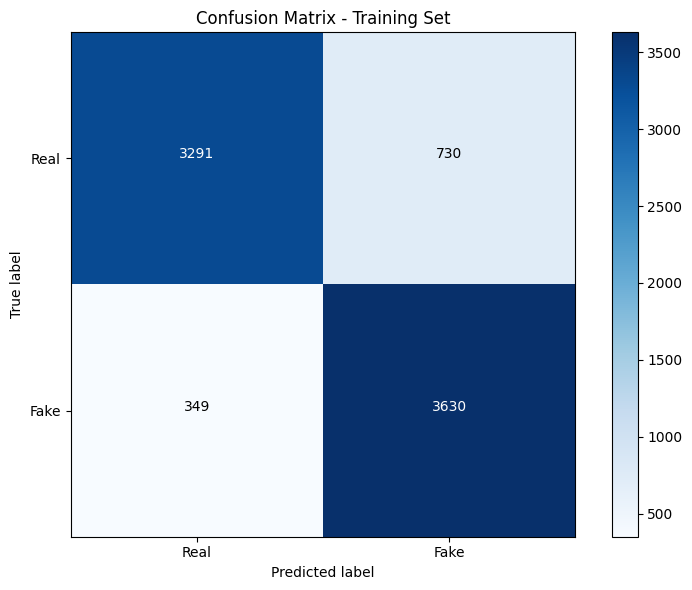

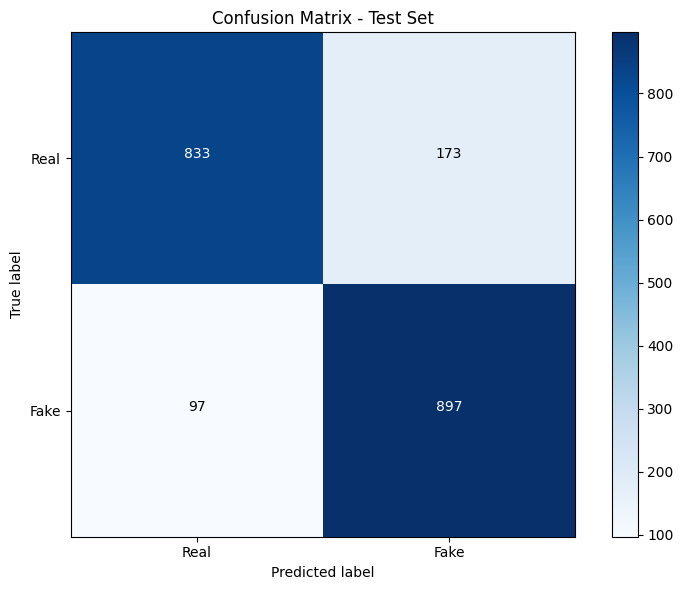

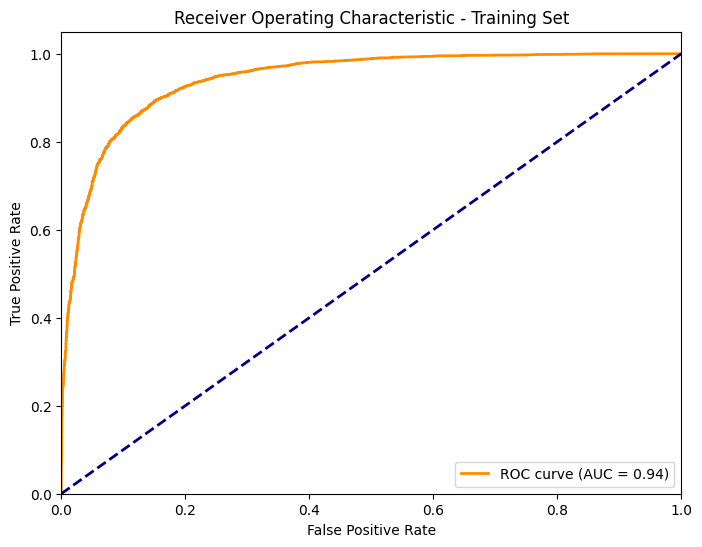

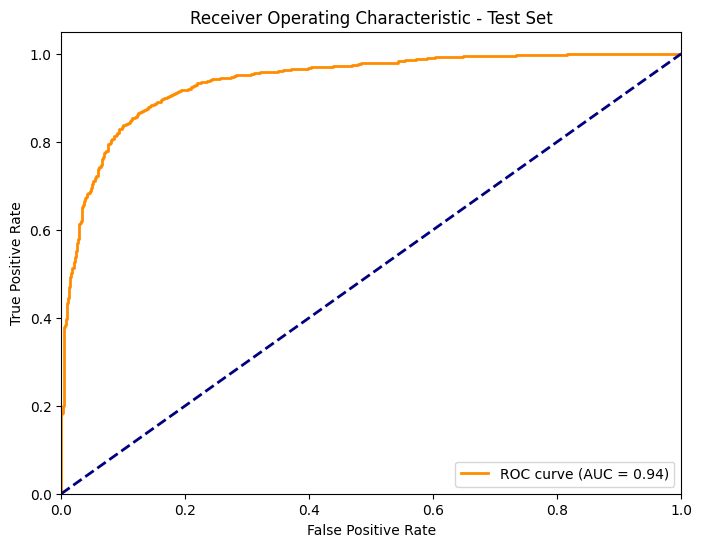

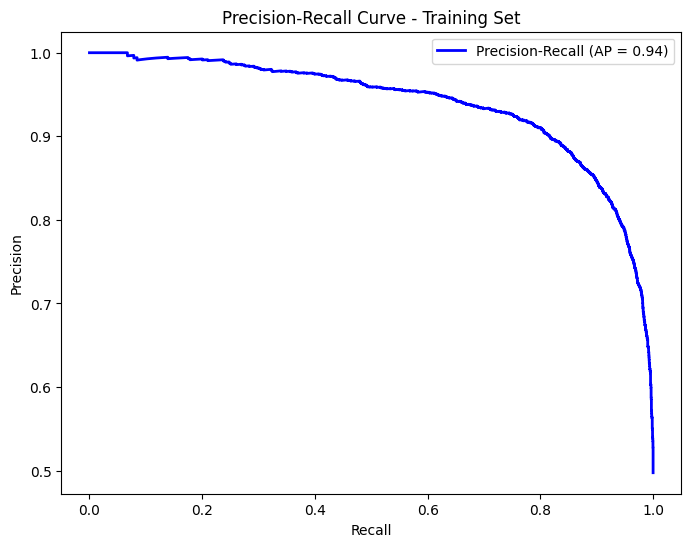

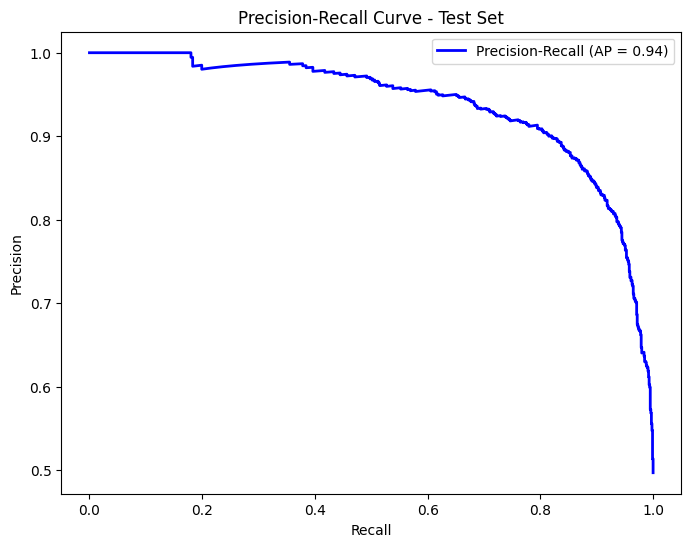


Advanced Metrics (Training Set):
                      Value
Accuracy           0.865125
Balanced Accuracy  0.865371
Precision          0.832569
Recall             0.912290
F1 Score           0.870608
MCC                0.733710
Cohen's Kappa      0.730377
Log Loss           0.319334
ROC AUC            0.942199
PR AUC             0.938985

Advanced Metrics (Test Set):
                      Value
Accuracy           0.865000
Balanced Accuracy  0.865223
Precision          0.838318
Recall             0.902414
F1 Score           0.869186
MCC                0.732229
Cohen's Kappa      0.730113
Log Loss           0.327100
ROC AUC            0.938545
PR AUC             0.938665

Class-wise Metrics (Training Set):
  Class    TP   FP    TN   FN  Sensitivity  Specificity       PPV       NPV
0  Real  3291  730  3630  349     0.818453     0.912290  0.904121  0.912290
1  Fake  3630  349  3291  730     0.912290     0.818453  0.832569  0.818453

Class-wise Metrics (Test Set):
  Class   TP   FP   TN  

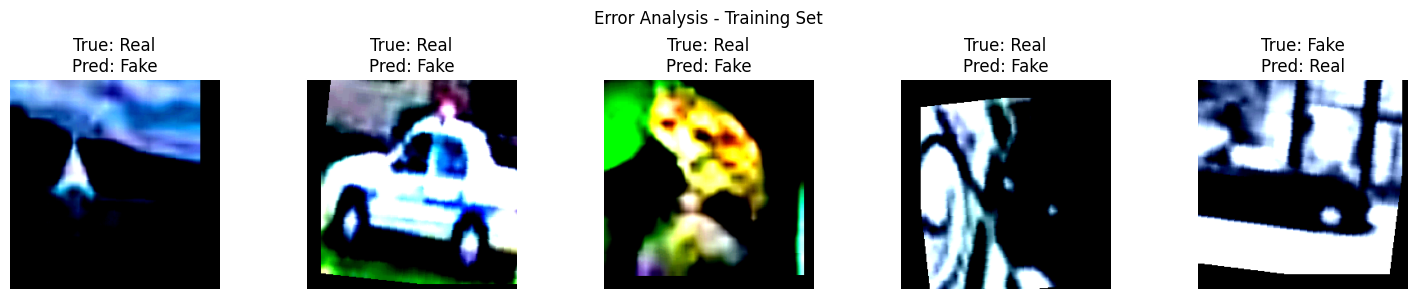


Error Analysis (Test Set):


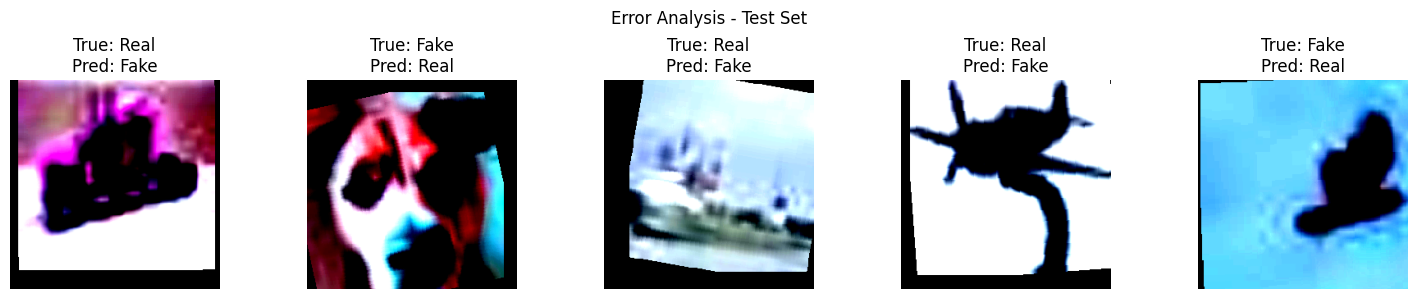


Threshold Analysis (Training Set):


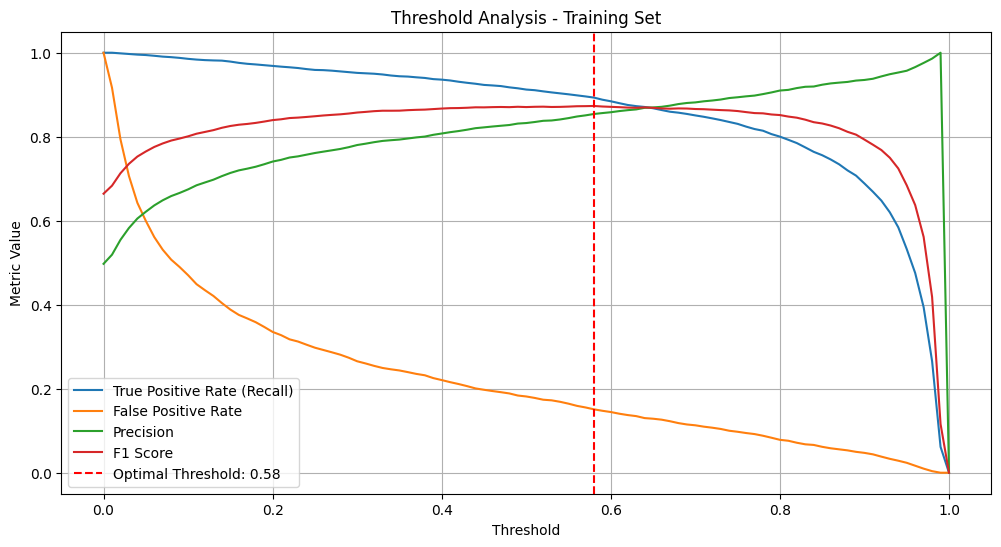

Optimal Decision Threshold (Training Set): 0.5800

Threshold Analysis (Test Set):


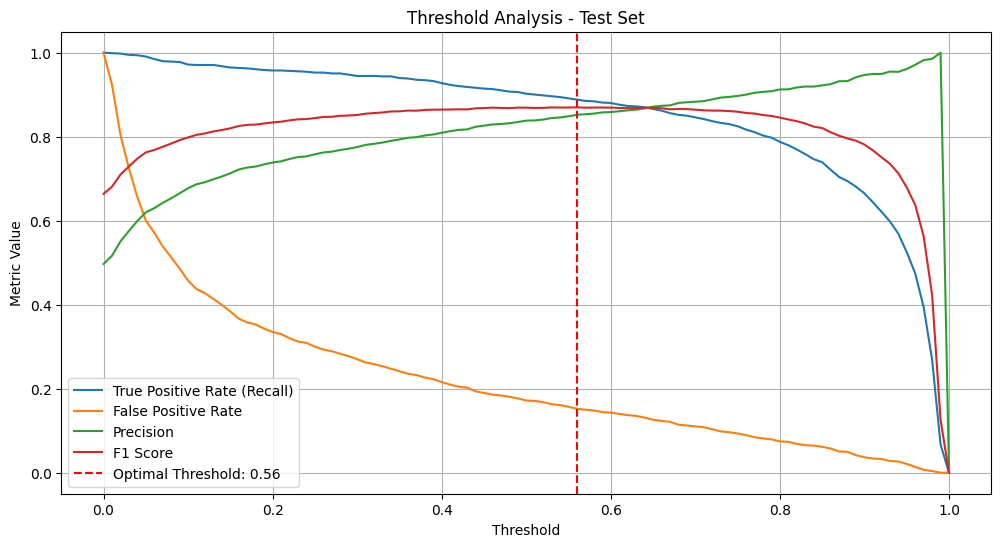

Optimal Decision Threshold (Test Set): 0.5600


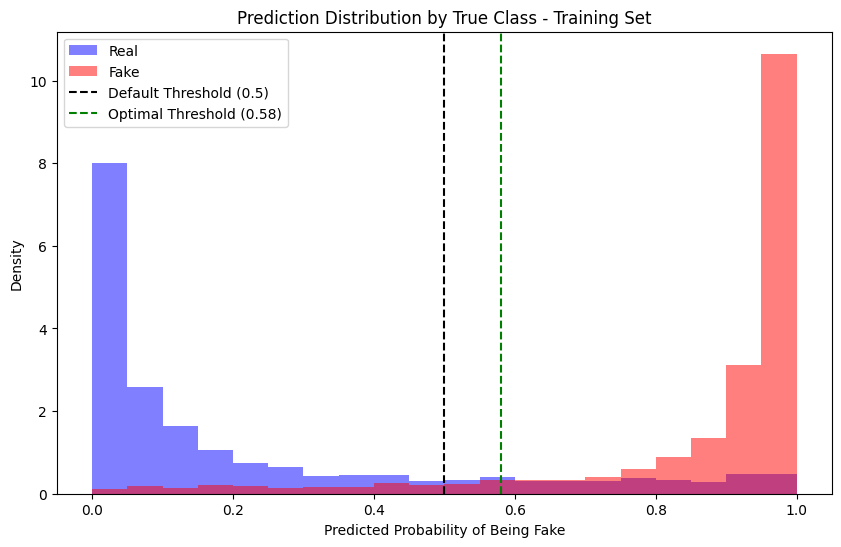

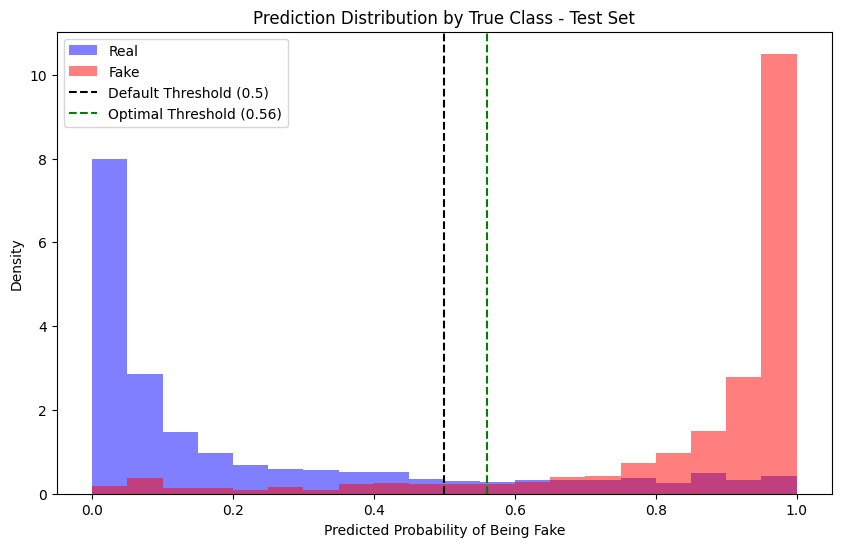


Training vs Testing Performance Comparison:


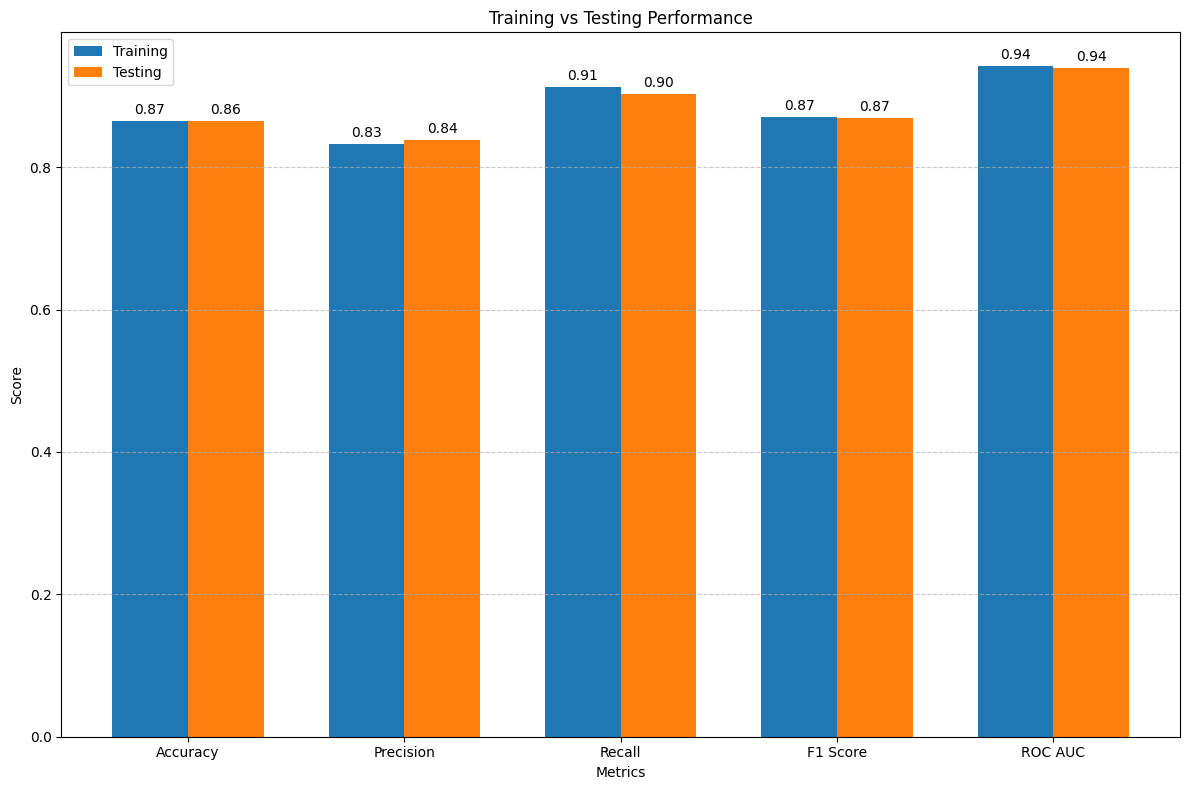

                              Metric  Training   Testing  Difference
Accuracy                    Accuracy  0.865125  0.865000   -0.000125
Balanced Accuracy  Balanced Accuracy  0.865371  0.865223   -0.000148
Precision                  Precision  0.832569  0.838318    0.005749
Recall                        Recall  0.912290  0.902414   -0.009875
F1 Score                    F1 Score  0.870608  0.869186   -0.001422
MCC                              MCC  0.733710  0.732229   -0.001481
Cohen's Kappa          Cohen's Kappa  0.730377  0.730113   -0.000264
Log Loss                    Log Loss  0.319334  0.327100    0.007765
ROC AUC                      ROC AUC  0.942199  0.938545   -0.003654
PR AUC                        PR AUC  0.938985  0.938665   -0.000320

==== MODEL ASSESSMENT SUMMARY ====
Model: MultiDomainFeatureFusionModel
Training Accuracy: 0.8651
Testing Accuracy: 0.8650
Accuracy Gap (Train-Test): 0.0001

Training F1 Score: 0.8706
Testing F1 Score: 0.8692
F1 Score Gap (Train-Test): 0.00

In [5]:

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, cohen_kappa_score, log_loss, balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Load the saved model
model_path = 'real_fake_fusion_model.pth'
model = MultiDomainFeatureFusionModel().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Function to get all predictions and true labels
def get_all_predictions(model, loader):
    all_preds = []
    all_probs = []
    all_labels = []
    all_inputs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Get probabilities and predictions
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_inputs.append(inputs.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    return torch.cat(all_inputs), torch.cat(all_preds), torch.cat(all_probs), torch.cat(all_labels)

# Get predictions for both datasets
print("Evaluating train dataset:")
train_inputs, train_preds, train_probs, train_labels = get_all_predictions(model, train_loader)
print("Evaluating test dataset:")
test_inputs, test_preds, test_probs, test_labels = get_all_predictions(model, test_loader)

# Convert to numpy for both datasets
train_y_true = train_labels.numpy()
train_y_pred = train_preds.numpy()
train_y_probs = train_probs.numpy()[:, 1]  # Probability of class 1 (fake)

test_y_true = test_labels.numpy()
test_y_pred = test_preds.numpy()
test_y_probs = test_probs.numpy()[:, 1]  # Probability of class 1 (fake)

# 1. Classification Report for both datasets
print("\nClassification Report (Training Set):")
print(classification_report(train_y_true, train_y_pred, target_names=['Real', 'Fake']))

print("\nClassification Report (Test Set):")
print(classification_report(test_y_true, test_y_pred, target_names=['Real', 'Fake']))

# 2. Confusion Matrix using matplotlib instead of seaborn
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.colorbar()
    
    classes = ['Real', 'Fake']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(train_y_true, train_y_pred, "Training Set")
plot_confusion_matrix(test_y_true, test_y_pred, "Test Set")

# 3. ROC Curve and AUC for both datasets
def plot_roc_curve(y_true, y_probs, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(train_y_true, train_y_probs, "Training Set")
plot_roc_curve(test_y_true, test_y_probs, "Test Set")

# 4. Precision-Recall Curve for both datasets
def plot_precision_recall(y_true, y_probs, dataset_name):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'Precision-Recall (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name}')
    plt.legend(loc="upper right")
    plt.show()

plot_precision_recall(train_y_true, train_y_probs, "Training Set")
plot_precision_recall(test_y_true, test_y_probs, "Test Set")

# 5. Advanced Metrics Table for both datasets
def calculate_advanced_metrics(y_true, y_pred, y_probs):
    # Calculate ROC curve values for AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc_value = auc(fpr, tpr)
    
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),  # Explicitly using f1_score from sklearn.metrics
        'MCC': matthews_corrcoef(y_true, y_pred),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
        'Log Loss': log_loss(y_true, y_probs),
        'ROC AUC': roc_auc_value,
        'PR AUC': average_precision_score(y_true, y_probs)
    }
    
    return pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

train_advanced_metrics = calculate_advanced_metrics(train_y_true, train_y_pred, train_y_probs)
print("\nAdvanced Metrics (Training Set):")
print(train_advanced_metrics)

test_advanced_metrics = calculate_advanced_metrics(test_y_true, test_y_pred, test_y_probs)
print("\nAdvanced Metrics (Test Set):")
print(test_advanced_metrics)

# 6. Class-wise Metrics for both datasets
def class_wise_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Handle potential division by zero
    def safe_division(x, y):
        return x / y if y != 0 else 0
    
    metrics = {
        'Class': ['Real', 'Fake'],
        'TP': [tn, tp],  # For Real, TN is like TP
        'FP': [fp, fn],  # For Real, FP is like FN
        'TN': [tp, tn],  # For Real, TP is like TN
        'FN': [fn, fp],  # For Real, FN is like FP
        'Sensitivity': [safe_division(tn, (tn+fp)), safe_division(tp, (tp+fn))],
        'Specificity': [safe_division(tp, (tp+fn)), safe_division(tn, (tn+fp))],
        'PPV': [safe_division(tn, (tn+fn)), safe_division(tp, (tp+fp))],
        'NPV': [safe_division(tp, (tp+fn)), safe_division(tn, (tn+fp))]
    }
    
    return pd.DataFrame(metrics)

train_class_metrics = class_wise_metrics(train_y_true, train_y_pred)
print("\nClass-wise Metrics (Training Set):")
print(train_class_metrics)

test_class_metrics = class_wise_metrics(test_y_true, test_y_pred)
print("\nClass-wise Metrics (Test Set):")
print(test_class_metrics)

# 7. Error Analysis for both datasets
def analyze_errors(model, inputs, preds, labels, dataset_name, num_samples=5):
    # Find misclassified samples
    incorrect_mask = ~preds.eq(labels)
    incorrect_indices = torch.where(incorrect_mask)[0]
    
    if len(incorrect_indices) == 0:
        print(f"No misclassifications found in the {dataset_name}")
        return
    
    # Limit to the requested number of samples
    sample_count = min(num_samples, len(incorrect_indices))
    selected_indices = incorrect_indices[:sample_count]
    
    # Visualize errors
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, sample_count, i+1)
        plt.imshow(inputs[idx].permute(1, 2, 0))
        plt.title(f"True: {'Fake' if labels[idx] else 'Real'}\n"
                 f"Pred: {'Fake' if preds[idx] else 'Real'}")
        plt.axis('off')
    plt.suptitle(f"Error Analysis - {dataset_name}")
    plt.tight_layout()
    plt.show()

print("\nError Analysis (Training Set):")
analyze_errors(model, train_inputs, train_preds, train_labels, "Training Set")

print("\nError Analysis (Test Set):")
analyze_errors(model, test_inputs, test_preds, test_labels, "Test Set")

# 8. Threshold Analysis for both datasets
def threshold_analysis(y_true, y_probs, dataset_name):
    thresholds = np.linspace(0, 1, 101)
    metrics = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_probs >= thresh).astype(int)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred_thresh)
        tn, fp, fn, tp = cm.ravel()
        
        # Handle division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        # Calculate F1 score explicitly to avoid potential issues
        f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
        
        metrics.append({
            'Threshold': thresh,
            'TPR': tpr,
            'FPR': fpr,
            'Precision': precision,
            'F1': f1
        })
    
    df = pd.DataFrame(metrics)
    
    # Plot metrics vs threshold
    plt.figure(figsize=(12, 6))
    plt.plot(df['Threshold'], df['TPR'], label='True Positive Rate (Recall)')
    plt.plot(df['Threshold'], df['FPR'], label='False Positive Rate')
    plt.plot(df['Threshold'], df['Precision'], label='Precision')
    plt.plot(df['Threshold'], df['F1'], label='F1 Score')
    
    # Find optimal threshold (max F1)
    if df['F1'].max() > 0:
        optimal_idx = df['F1'].idxmax()
        optimal_thresh = df.loc[optimal_idx, 'Threshold']
        plt.axvline(x=optimal_thresh, color='r', linestyle='--', 
                    label=f'Optimal Threshold: {optimal_thresh:.2f}')
    
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title(f'Threshold Analysis - {dataset_name}')
    plt.legend()
    plt.grid()
    plt.show()
    
    optimal_threshold = df.loc[df['F1'].idxmax(), 'Threshold'] if df['F1'].max() > 0 else 0.5
    return optimal_threshold

print("\nThreshold Analysis (Training Set):")
train_optimal_threshold = threshold_analysis(train_y_true, train_y_probs, "Training Set")
print(f"Optimal Decision Threshold (Training Set): {train_optimal_threshold:.4f}")

print("\nThreshold Analysis (Test Set):")
test_optimal_threshold = threshold_analysis(test_y_true, test_y_probs, "Test Set")
print(f"Optimal Decision Threshold (Test Set): {test_optimal_threshold:.4f}")

# 9. Prediction Distribution for both datasets
def plot_prediction_distribution(y_true, y_probs, optimal_threshold, dataset_name):
    plt.figure(figsize=(10, 6))
    
    # Create bins for histograms
    bins = np.linspace(0, 1, 21)
    
    # Plot histograms for each class
    real_probs = y_probs[y_true == 0]
    fake_probs = y_probs[y_true == 1]
    
    if len(real_probs) > 0:
        plt.hist(real_probs, bins=bins, alpha=0.5, color='blue', 
                 label='Real', density=True)
    
    if len(fake_probs) > 0:
        plt.hist(fake_probs, bins=bins, alpha=0.5, color='red', 
                 label='Fake', density=True)
    
    plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
    plt.axvline(x=optimal_threshold, color='green', linestyle='--', 
                label=f'Optimal Threshold ({optimal_threshold:.2f})')
    
    plt.xlabel('Predicted Probability of Being Fake')
    plt.ylabel('Density')
    plt.title(f'Prediction Distribution by True Class - {dataset_name}')
    plt.legend()
    plt.show()

plot_prediction_distribution(train_y_true, train_y_probs, train_optimal_threshold, "Training Set")
plot_prediction_distribution(test_y_true, test_y_probs, test_optimal_threshold, "Test Set")

# 10. Compare Training vs Testing Performance
def compare_datasets_performance():
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Metric': train_advanced_metrics.index,
        'Training': train_advanced_metrics['Value'],
        'Testing': test_advanced_metrics['Value'],
        'Difference': test_advanced_metrics['Value'] - train_advanced_metrics['Value']
    })
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    comparison_subset = comparison[comparison['Metric'].isin(metrics_to_plot)]
    
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    plt.bar(x - width/2, comparison_subset['Training'], width, label='Training')
    plt.bar(x + width/2, comparison_subset['Testing'], width, label='Testing')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Training vs Testing Performance')
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    for i, v in enumerate(comparison_subset['Training']):
        plt.text(i - width/2, v + 0.01, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(comparison_subset['Testing']):
        plt.text(i + width/2, v + 0.01, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return comparison

print("\nTraining vs Testing Performance Comparison:")
performance_comparison = compare_datasets_performance()
print(performance_comparison)

# 11. Overall Model Assessment Summary
def print_model_assessment_summary():
    print("\n==== MODEL ASSESSMENT SUMMARY ====")
    
    # Calculate overfitting metrics
    accuracy_diff = train_advanced_metrics.loc['Accuracy', 'Value'] - test_advanced_metrics.loc['Accuracy', 'Value']
    f1_diff = train_advanced_metrics.loc['F1 Score', 'Value'] - test_advanced_metrics.loc['F1 Score', 'Value']
    
    print(f"Model: MultiDomainFeatureFusionModel")
    print(f"Training Accuracy: {train_advanced_metrics.loc['Accuracy', 'Value']:.4f}")
    print(f"Testing Accuracy: {test_advanced_metrics.loc['Accuracy', 'Value']:.4f}")
    print(f"Accuracy Gap (Train-Test): {accuracy_diff:.4f}")
    
    print(f"\nTraining F1 Score: {train_advanced_metrics.loc['F1 Score', 'Value']:.4f}")
    print(f"Testing F1 Score: {test_advanced_metrics.loc['F1 Score', 'Value']:.4f}")
    print(f"F1 Score Gap (Train-Test): {f1_diff:.4f}")
    
    # Assess overfitting
    if accuracy_diff > 0.05:
        print("\nPotential overfitting detected: The model performs significantly better on training data than test data.")
        print("Consider regularization techniques or collecting more diverse training data.")
    else:
        print("\nNo significant overfitting detected: Model performs similarly on training and test data.")
    
    # Assess model quality based on test metrics
    test_f1 = test_advanced_metrics.loc['F1 Score', 'Value']
    if test_f1 > 0.9:
        model_quality = "Excellent"
    elif test_f1 > 0.8:
        model_quality = "Good"
    elif test_f1 > 0.7:
        model_quality = "Fair"
    else:
        model_quality = "Needs improvement"
    
    print(f"\nOverall Model Quality: {model_quality}")
    print(f"Optimal Threshold (based on F1): {test_optimal_threshold:.4f}")
    
    # Class-specific assessment
    real_sensitivity = test_class_metrics.loc[0, 'Sensitivity']
    fake_sensitivity = test_class_metrics.loc[1, 'Sensitivity']
    
    print(f"\nReal Image Detection Sensitivity: {real_sensitivity:.4f}")
    print(f"Fake Image Detection Sensitivity: {fake_sensitivity:.4f}")
    
    if abs(real_sensitivity - fake_sensitivity) > 0.1:
        imbalance_class = "Real" if real_sensitivity > fake_sensitivity else "Fake"
        print(f"Class imbalance detected: Model performs better on '{imbalance_class}' class.")
        print("Consider balanced training techniques or adjusting the decision threshold.")

print_model_assessment_summary()